In [1]:
import tensorflow as tf
from tensorflow import keras
import optuna
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import scipy

print("TensorFlow Version:", tf.__version__)
print("Keras Version:", keras.__version__)
print("NumPy Version:", np.__version__)
print("Pandas Version:", pd.__version__)
print("Optuna Version:", optuna.__version__)
print("Scipy Version:", scipy.__version__)


TensorFlow Version: 2.20.0
Keras Version: 3.11.3
NumPy Version: 1.26.4
Pandas Version: 2.3.3
Optuna Version: 4.5.0
Scipy Version: 1.13.1


In [2]:
import tensorflow as tf


import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten,  Dropout, SpatialDropout2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Nadam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing import image
from sklearn.metrics import roc_auc_score


In [3]:
tf.__version__

'2.20.0'

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [5]:
training_set = train_datagen.flow_from_directory(r'C:\Users\Aysel Quliyeva\Desktop\data science with python\exam data\dl models\zip face\face_expression_data\face_expression_data\train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 682 images belonging to 7 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory(r'C:\Users\Aysel Quliyeva\Desktop\data science with python\exam data\dl models\zip face\face_expression_data\face_expression_data\test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 299 images belonging to 7 classes.


In [7]:
def create_model(trial):
    model = Sequential()
    
    """ 1. CNN Network """
    filters1 = trial.suggest_int('filters1', 16, 64)
    filters2 = trial.suggest_int('filters2', 16, 64)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    pool_size = trial.suggest_int('pool_size', 2, 3)
    strides = trial.suggest_int('strides', 1, 2)
    
    model.add(Conv2D(filters=filters1, kernel_size=kernel_size, 
                     activation='relu', input_shape=[64, 64, 3]))
    model.add(MaxPool2D(pool_size=pool_size, strides=strides))
    model.add(SpatialDropout2D(trial.suggest_float("dropout_conv1", 0.1, 0.5)))
    
    model.add(Conv2D(filters=filters2, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPool2D(pool_size=pool_size, strides=strides))
    model.add(SpatialDropout2D(trial.suggest_float("dropout_conv2", 0.1, 0.5)))
    
    model.add(Flatten())
    
    """ 2. RNN Network """
    # Reshape for RNN (sequence, features)
    rnn_units = trial.suggest_int('rnn_units', 32, 128)
    model.add(Reshape((1, -1)))  # Convert to sequence format
    
    rnn_type = trial.suggest_categorical('rnn_type', ['LSTM', 'GRU'])
    if rnn_type == 'LSTM':
        model.add(LSTM(units=rnn_units, return_sequences=False))
    else:
        model.add(GRU(units=rnn_units, return_sequences=False))
    
    model.add(Dropout(trial.suggest_float("dropout_rnn", 0.1, 0.5)))
    
    """ 3. ANN Network """
    model.add(Dense(units=trial.suggest_int('units_layer1', 32, 128), activation='relu'))
    model.add(Dropout(trial.suggest_float("dropout_ann1", 0.1, 0.5)))
    
    model.add(Dense(units=trial.suggest_int('units_layer2', 16, 64), activation='relu'))
    model.add(Dropout(trial.suggest_float("dropout_ann2", 0.1, 0.5)))
    
    model.add(Dense(units=7, activation='softmax'))
    
    """ 4. Optimizer with Gradient Clipping """
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop', 'adagrad'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    clip_value = trial.suggest_float('clip_value', 0.1, 2.0)
    
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate, clipvalue=clip_value)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, clipvalue=clip_value)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate, clipvalue=clip_value)
    elif optimizer_name == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate, clipvalue=clip_value)
    
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [8]:
def objective(trial):
    # EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        mode='max'
    )
    
    model = create_model(trial)
    
    history = model.fit(
        training_set,
        validation_data=test_set,
        epochs=50,  # Increased for early stopping
        batch_size=trial.suggest_int('batch_size', 16, 64),
        callbacks=[early_stopping],
        verbose=0
    )
    
    test_loss, test_accuracy = model.evaluate(test_set, verbose=0)
    return test_accuracy

In [13]:
# Hyperparameter optimization
from optuna.samplers import TPESampler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import (Input, TimeDistributed, Conv2D, MaxPooling2D,
                                     SpatialDropout2D, Flatten, LSTM, GRU, Dropout,
                                     Dense, Reshape)


tpe_sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=tpe_sampler)
study.optimize(objective, n_trials=10)  # Increased trials

print(f"Best trial: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_trial.params}")

# Get best parameters
best_params = study.best_trial.params


[I 2025-10-28 11:53:31,979] A new study created in memory with name: no-name-5b33f890-d536-432e-9b32-f0759f2a32ad
C:\Users\Aysel Quliyeva\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[I 2025-10-28 12:06:50,882] Trial 0 finished with value: 0.9431437849998474 and parameters: {'filters1': 34, 'filters2': 62, 'kernel_size': 4, 'pool_size': 3, 'strides': 1, 'dropout_conv1': 0.16239780813448107, 'dropout_conv2': 0.12323344486727979, 'rnn_units': 116, 'rnn_type': 'GRU', 'dropout_rnn': 0.10823379771832098, 'units_layer1': 126, 'dropout_ann1': 0.4329770563201687, 'units_layer2': 26, 'dropout_ann2': 0.17272998688284025, 'optimizer': 'rmsprop', 'learning_rate': 7.476312062252303e-05, 'c

Best trial: 0.9431437849998474
Best hyperparameters: {'filters1': 34, 'filters2': 62, 'kernel_size': 4, 'pool_size': 3, 'strides': 1, 'dropout_conv1': 0.16239780813448107, 'dropout_conv2': 0.12323344486727979, 'rnn_units': 116, 'rnn_type': 'GRU', 'dropout_rnn': 0.10823379771832098, 'units_layer1': 126, 'dropout_ann1': 0.4329770563201687, 'units_layer2': 26, 'dropout_ann2': 0.17272998688284025, 'optimizer': 'rmsprop', 'learning_rate': 7.476312062252303e-05, 'clip_value': 1.262520499972521, 'batch_size': 22}


In [14]:
def create_final_model(best_params):
    model = Sequential()
    
    """ 1. CNN Network """
    model.add(Conv2D(filters=best_params['filters1'], 
                     kernel_size=best_params['kernel_size'], 
                     activation='relu', input_shape=[64, 64, 3]))
    model.add(MaxPool2D(pool_size=best_params['pool_size'], 
                       strides=best_params['strides']))
    model.add(SpatialDropout2D(best_params['dropout_conv1']))
    
    model.add(Conv2D(filters=best_params['filters2'], 
                     kernel_size=best_params['kernel_size'], 
                     activation='relu'))
    model.add(MaxPool2D(pool_size=best_params['pool_size'], 
                       strides=best_params['strides']))
    model.add(SpatialDropout2D(best_params['dropout_conv2']))
    
    model.add(Flatten())
    
    """ 2. RNN Network """
    model.add(Reshape((1, -1)))
    
    if best_params['rnn_type'] == 'LSTM':
        model.add(LSTM(units=best_params['rnn_units'], return_sequences=False))
    else:
        model.add(GRU(units=best_params['rnn_units'], return_sequences=False))
    
    model.add(Dropout(best_params['dropout_rnn']))

    
    """ 3. ANN Network """
    model.add(Dense(units=best_params['units_layer1'], activation='relu'))
    model.add(Dropout(best_params['dropout_ann1']))
    
    model.add(Dense(units=best_params['units_layer2'], activation='relu'))
    model.add(Dropout(best_params['dropout_ann2']))
    
    model.add(Dense(units=7, activation='softmax'))
    
    """ 4. Optimizer with Gradient Clipping """
    learning_rate = best_params['learning_rate']
    clip_value = best_params['clip_value']
    
    if best_params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=learning_rate, clipvalue=clip_value)
    elif best_params['optimizer'] == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, clipvalue=clip_value)
    elif best_params['optimizer'] == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate, clipvalue=clip_value)
    elif best_params['optimizer'] == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate, clipvalue=clip_value)
    
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# Create and train final model
final_model = create_final_model(best_params)

# Train with early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    mode='max'
)

history = final_model.fit(
    training_set,
    validation_data=test_set,
    epochs=100,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping]
)

# Evaluate final model
train_loss, train_accuracy = final_model.evaluate(training_set)
test_loss, test_accuracy = final_model.evaluate(test_set)

print(f"Final Train Accuracy: {train_accuracy:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.2097 - loss: 1.9410 - val_accuracy: 0.2508 - val_loss: 1.9086
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 854ms/step - accuracy: 0.2258 - loss: 1.9094 - val_accuracy: 0.1806 - val_loss: 1.8651
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 839ms/step - accuracy: 0.2258 - loss: 1.8920 - val_accuracy: 0.1338 - val_loss: 1.8713
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 770ms/step - accuracy: 0.2287 - loss: 1.8929 - val_accuracy: 0.1773 - val_loss: 1.8649
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 791ms/step - accuracy: 0.2361 - loss: 1.8836 - val_accuracy: 0.2508 - val_loss: 1.8541
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 773ms/step - accuracy: 0.2258 - loss: 1.8816 - val_accuracy: 0.2508 - val_loss: 1.8450
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 781ms/step - accuracy: 0.2463 - loss: 1.8652 - val_accuracy: 0.2508 - val_loss: 1.8400
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 785ms/step - accuracy: 0.2463 - loss: 1.8787 - val

In [15]:
fin_mod = create_final_model(best_params)

In [16]:
fin_mod.fit(
    training_set, 
    validation_data=test_set, 
    epochs=20,  
    batch_size=best_params['batch_size']
)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 793ms/step - accuracy: 0.1716 - loss: 2.0083 - val_accuracy: 0.2107 - val_loss: 1.8809
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 730ms/step - accuracy: 0.2023 - loss: 1.9327 - val_accuracy: 0.2508 - val_loss: 1.8966
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 732ms/step - accuracy: 0.2053 - loss: 1.9335 - val_accuracy: 0.3411 - val_loss: 1.8724
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 739ms/step - accuracy: 0.2097 - loss: 1.9256 - val_accuracy: 0.2107 - val_loss: 1.8720
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 735ms/step - accuracy: 0.2170 - loss: 1.9023 - val_accuracy: 0.2107 - val_loss: 1.8486
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 742ms/step - accuracy: 0.2375 - loss: 1.9117 - val_accuracy: 0.2174 - val_loss: 1.8289
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 789ms/step - accuracy: 0.2654 - loss: 1.8543 - val_accuracy: 0.4381 - val_loss: 1.7595
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 746ms/step - accuracy: 0.2947 - loss: 1.8230 - val_accu

In [18]:
train_loss, train_accuracy = fin_mod.evaluate(training_set)
test_loss, test_accuracy = fin_mod.evaluate(test_set)

print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.6510 - loss: 0.9758
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.6120 - loss: 0.9368
Train Loss: 0.9758316278457642
Train Accuracy: 0.6510263681411743
Test Loss: 0.936776340007782
Test Accuracy: 0.6120401620864868


# deploy

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


,Image,Prediction
0,,happy
1,,disgust
2,,surprise
3,,surprise
4,,disgust
5,,surprise
6,,disgust
7,,surprise
8,,surprise
9,,happy

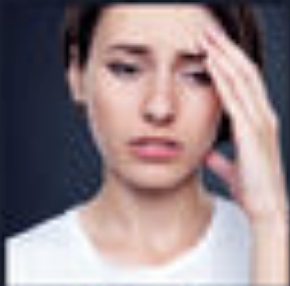
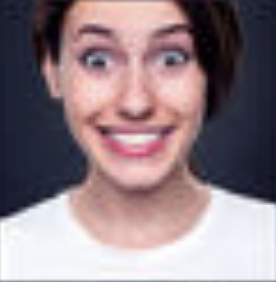
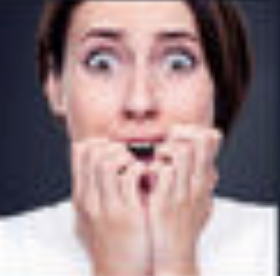
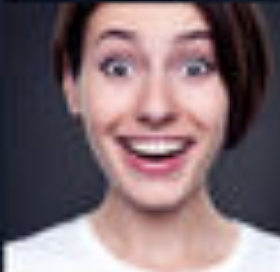
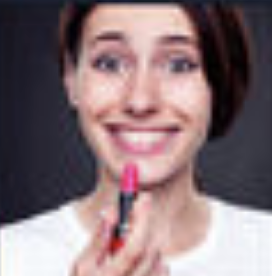
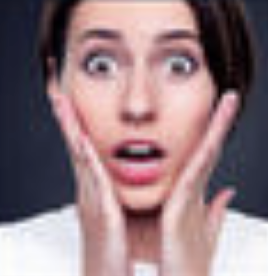
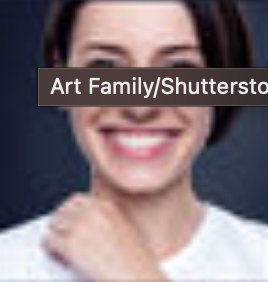
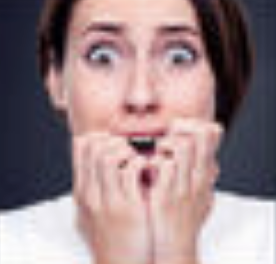
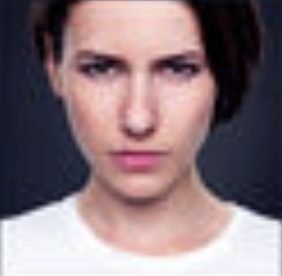
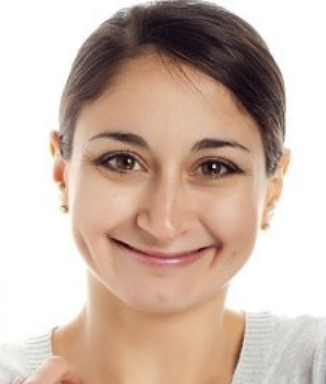
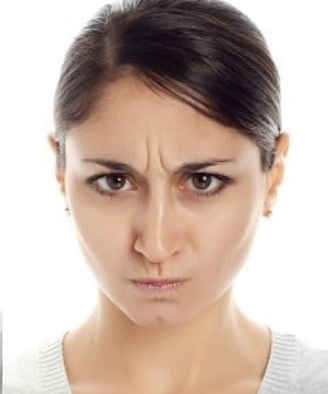
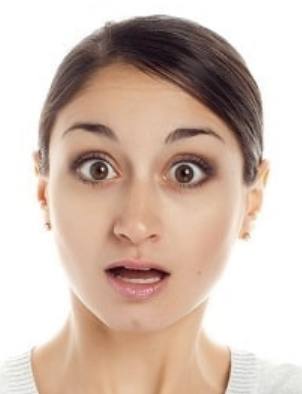
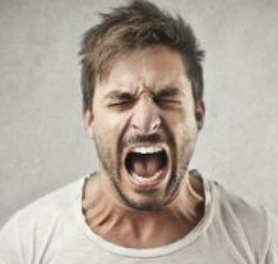
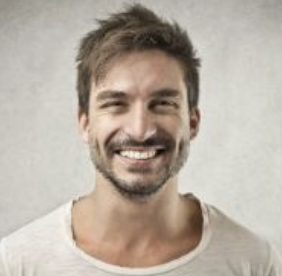
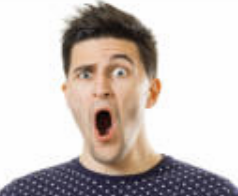
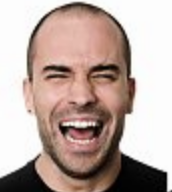
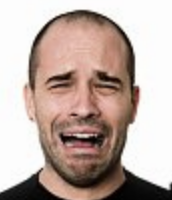

In [19]:
from IPython.display import Image, display
from io import BytesIO
import base64
import os
import numpy as np
import pandas as pd
from keras.preprocessing import image

def img_to_displayable_format(img_path):
    with open(img_path, "rb") as img_file:
        encoded_img = base64.b64encode(img_file.read()).decode('utf-8')
    return f'<img src="data:image/jpeg;base64,{encoded_img}" width="64" height="64"/>'

folder_path = r'C:\Users\Aysel Quliyeva\Desktop\data science with python\exam data\dl models\zip face\face_expression_data\face_expression_data\single_prediction'

results = []

# Reverse the dictionary to map from indices back to class names
class_names = {v: k for k, v in training_set.class_indices.items()}

for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.webp')):
        
        img_path = os.path.join(folder_path, filename)
        test_image = image.load_img(img_path, target_size=(64, 64))
        test_image_array = image.img_to_array(test_image)
        test_image_array = np.expand_dims(test_image_array, axis=0)

        result = fin_mod.predict(test_image_array / 255.0)

        predicted_class_index = np.argmax(result)

        prediction = class_names[predicted_class_index]

        img_display = img_to_displayable_format(img_path)
        results.append({'Image': img_display, 'Prediction': prediction})

df_results = pd.DataFrame(results)

from IPython.display import display, HTML
display(HTML(df_results.to_html(escape=False)))
